In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!pip install shap

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import shap
import seaborn as sns
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

# Load Dataset

Load the data for building energy efficiency.  Dataset can be found and downloaded from: https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set?select=energy_efficiency_data.csv

In [105]:
f = open('/content/drive/MyDrive/energy_efficiency_data.csv', 'r')
df = pd.read_csv(f, header=0)
f.close()
print(df)

     Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                    0.98         514.5      294.0     110.25             7.0   
1                    0.98         514.5      294.0     110.25             7.0   
2                    0.98         514.5      294.0     110.25             7.0   
3                    0.98         514.5      294.0     110.25             7.0   
4                    0.90         563.5      318.5     122.50             7.0   
..                    ...           ...        ...        ...             ...   
763                  0.64         784.0      343.0     220.50             3.5   
764                  0.62         808.5      367.5     220.50             3.5   
765                  0.62         808.5      367.5     220.50             3.5   
766                  0.62         808.5      367.5     220.50             3.5   
767                  0.62         808.5      367.5     220.50             3.5   

     Orientation  Glazing_A

# Data Exploration

In [106]:
df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


Split dataframe into x values and y values (heating and cooling loads are both response variables)

In [107]:
X = df[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']]
yh = df[['Heating_Load']]
yc = df[['Cooling_Load']]

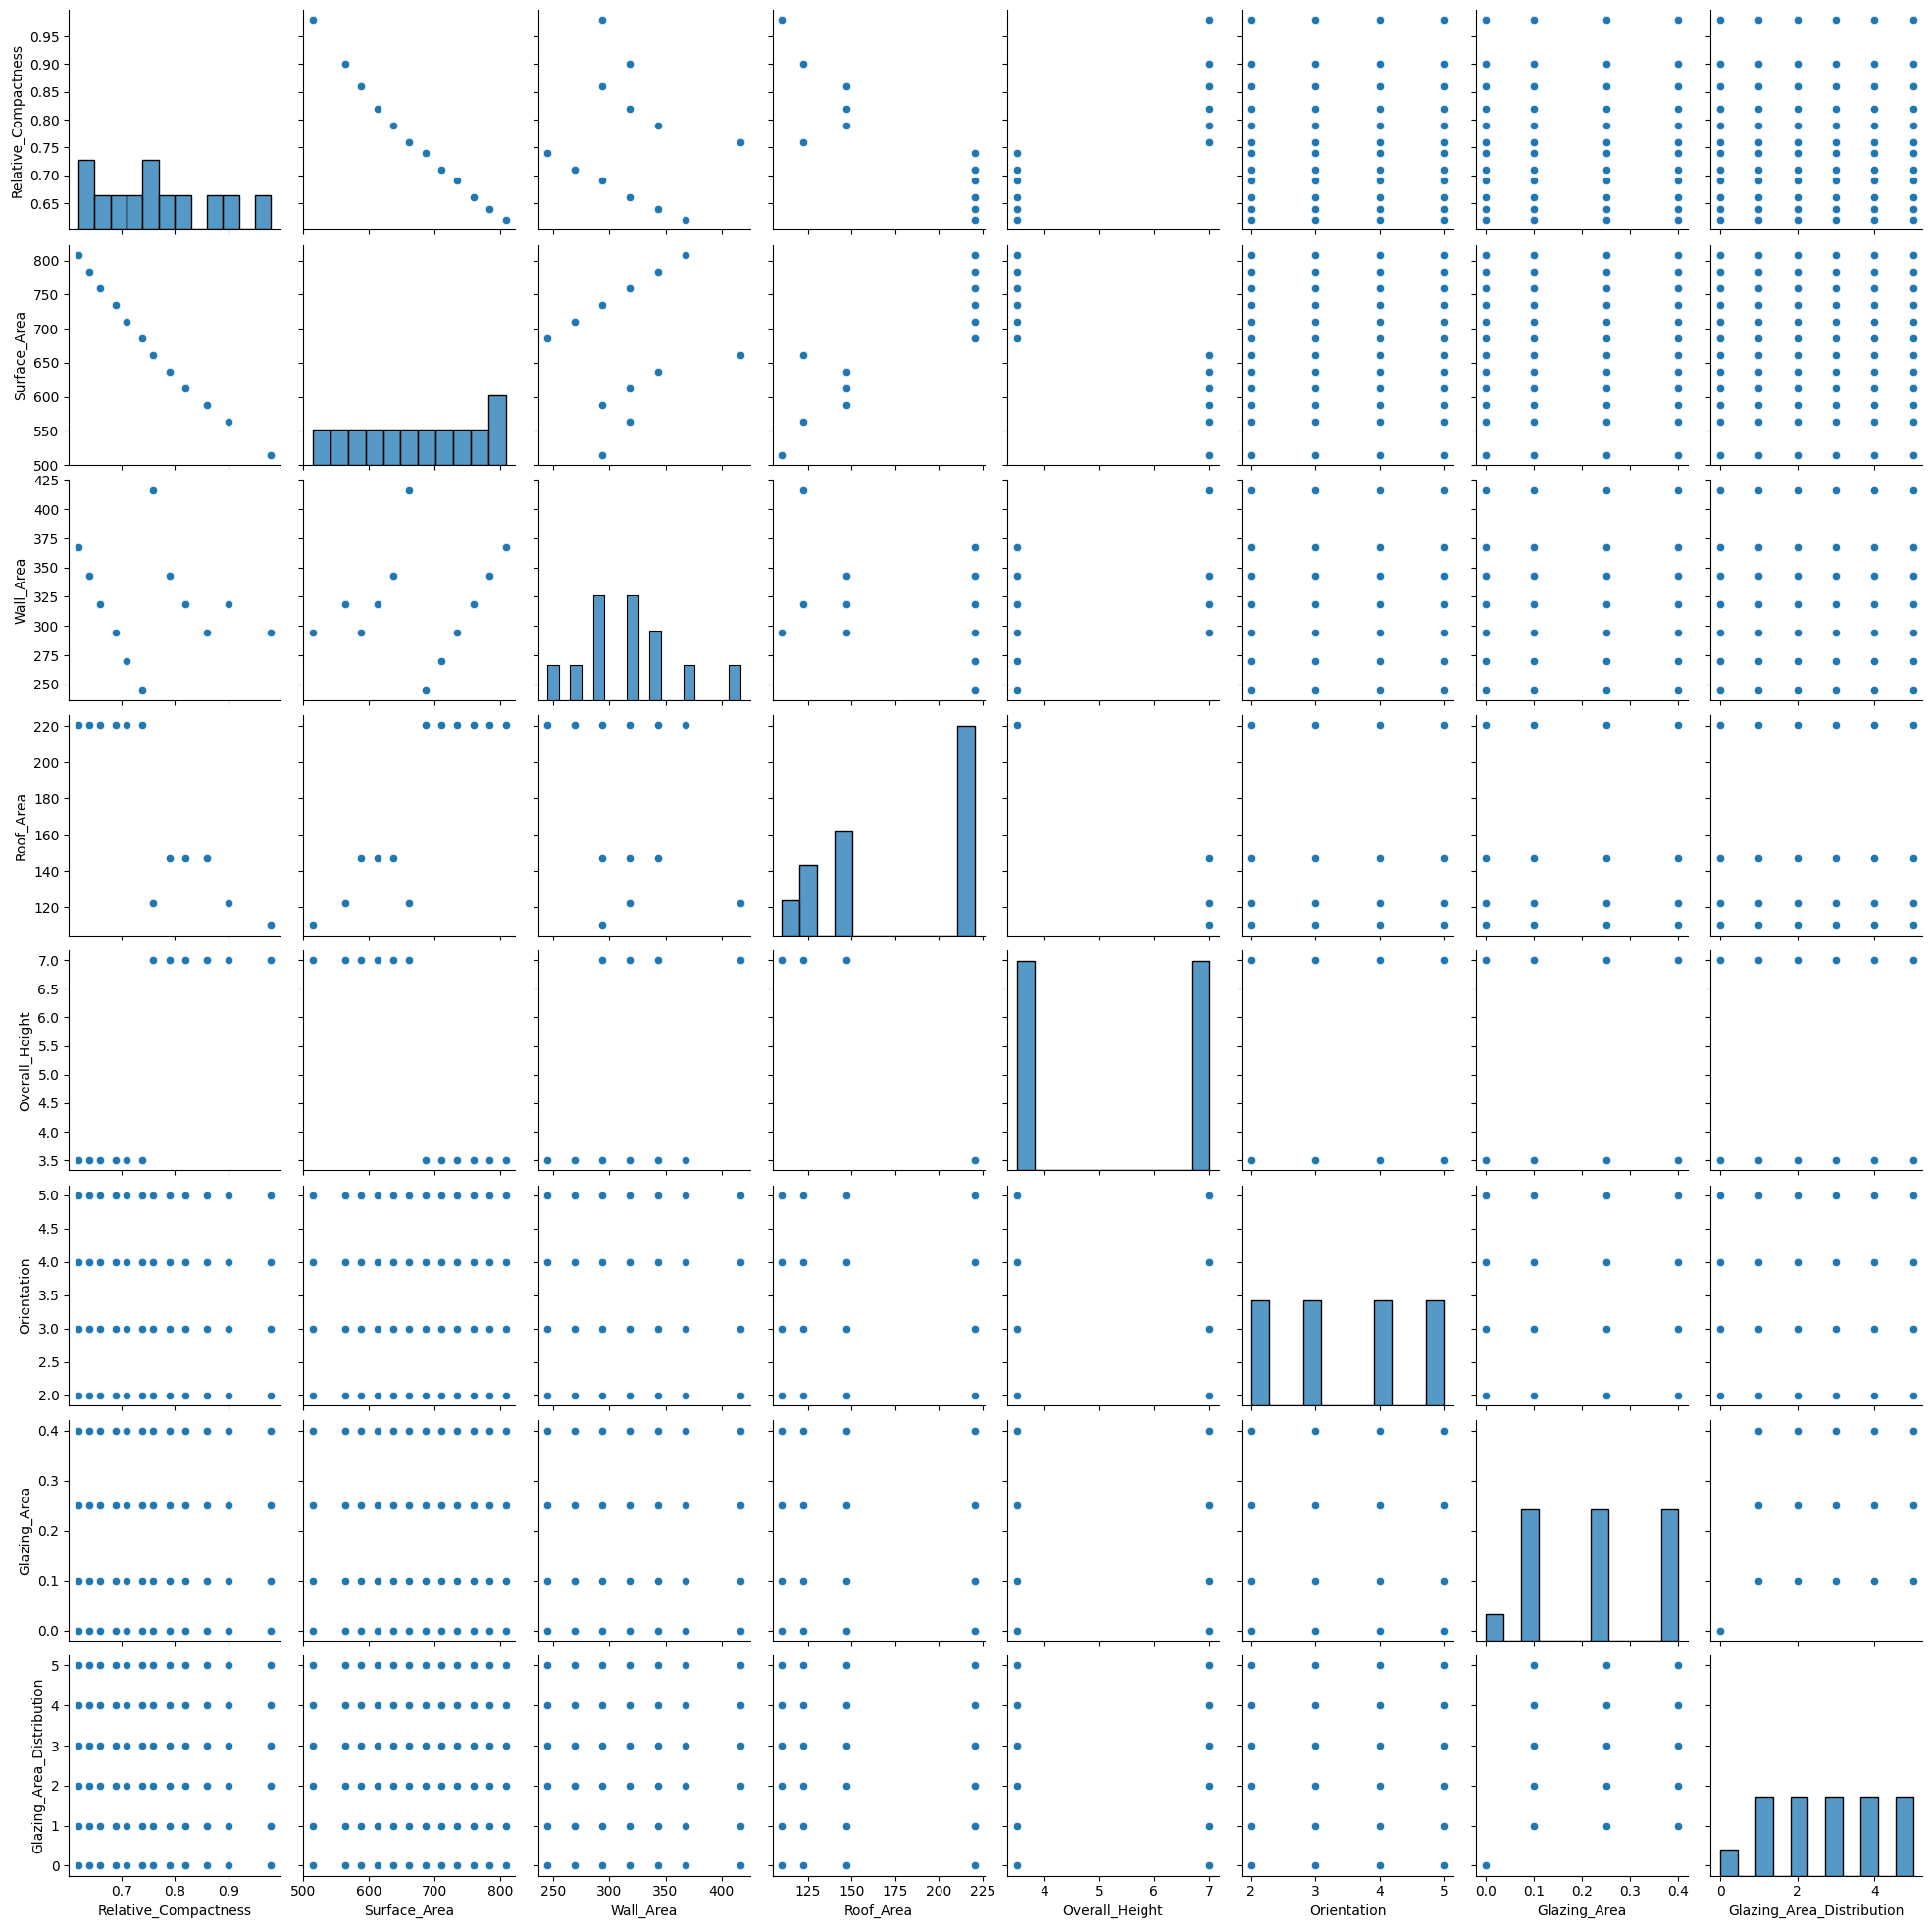

In [50]:
sns.pairplot(X)

You can see in the pairwise plots that overall height is a bifurcated feature.
 And I can infer that this dataset is built around one story and two story buildings.  Likely single family homes.  

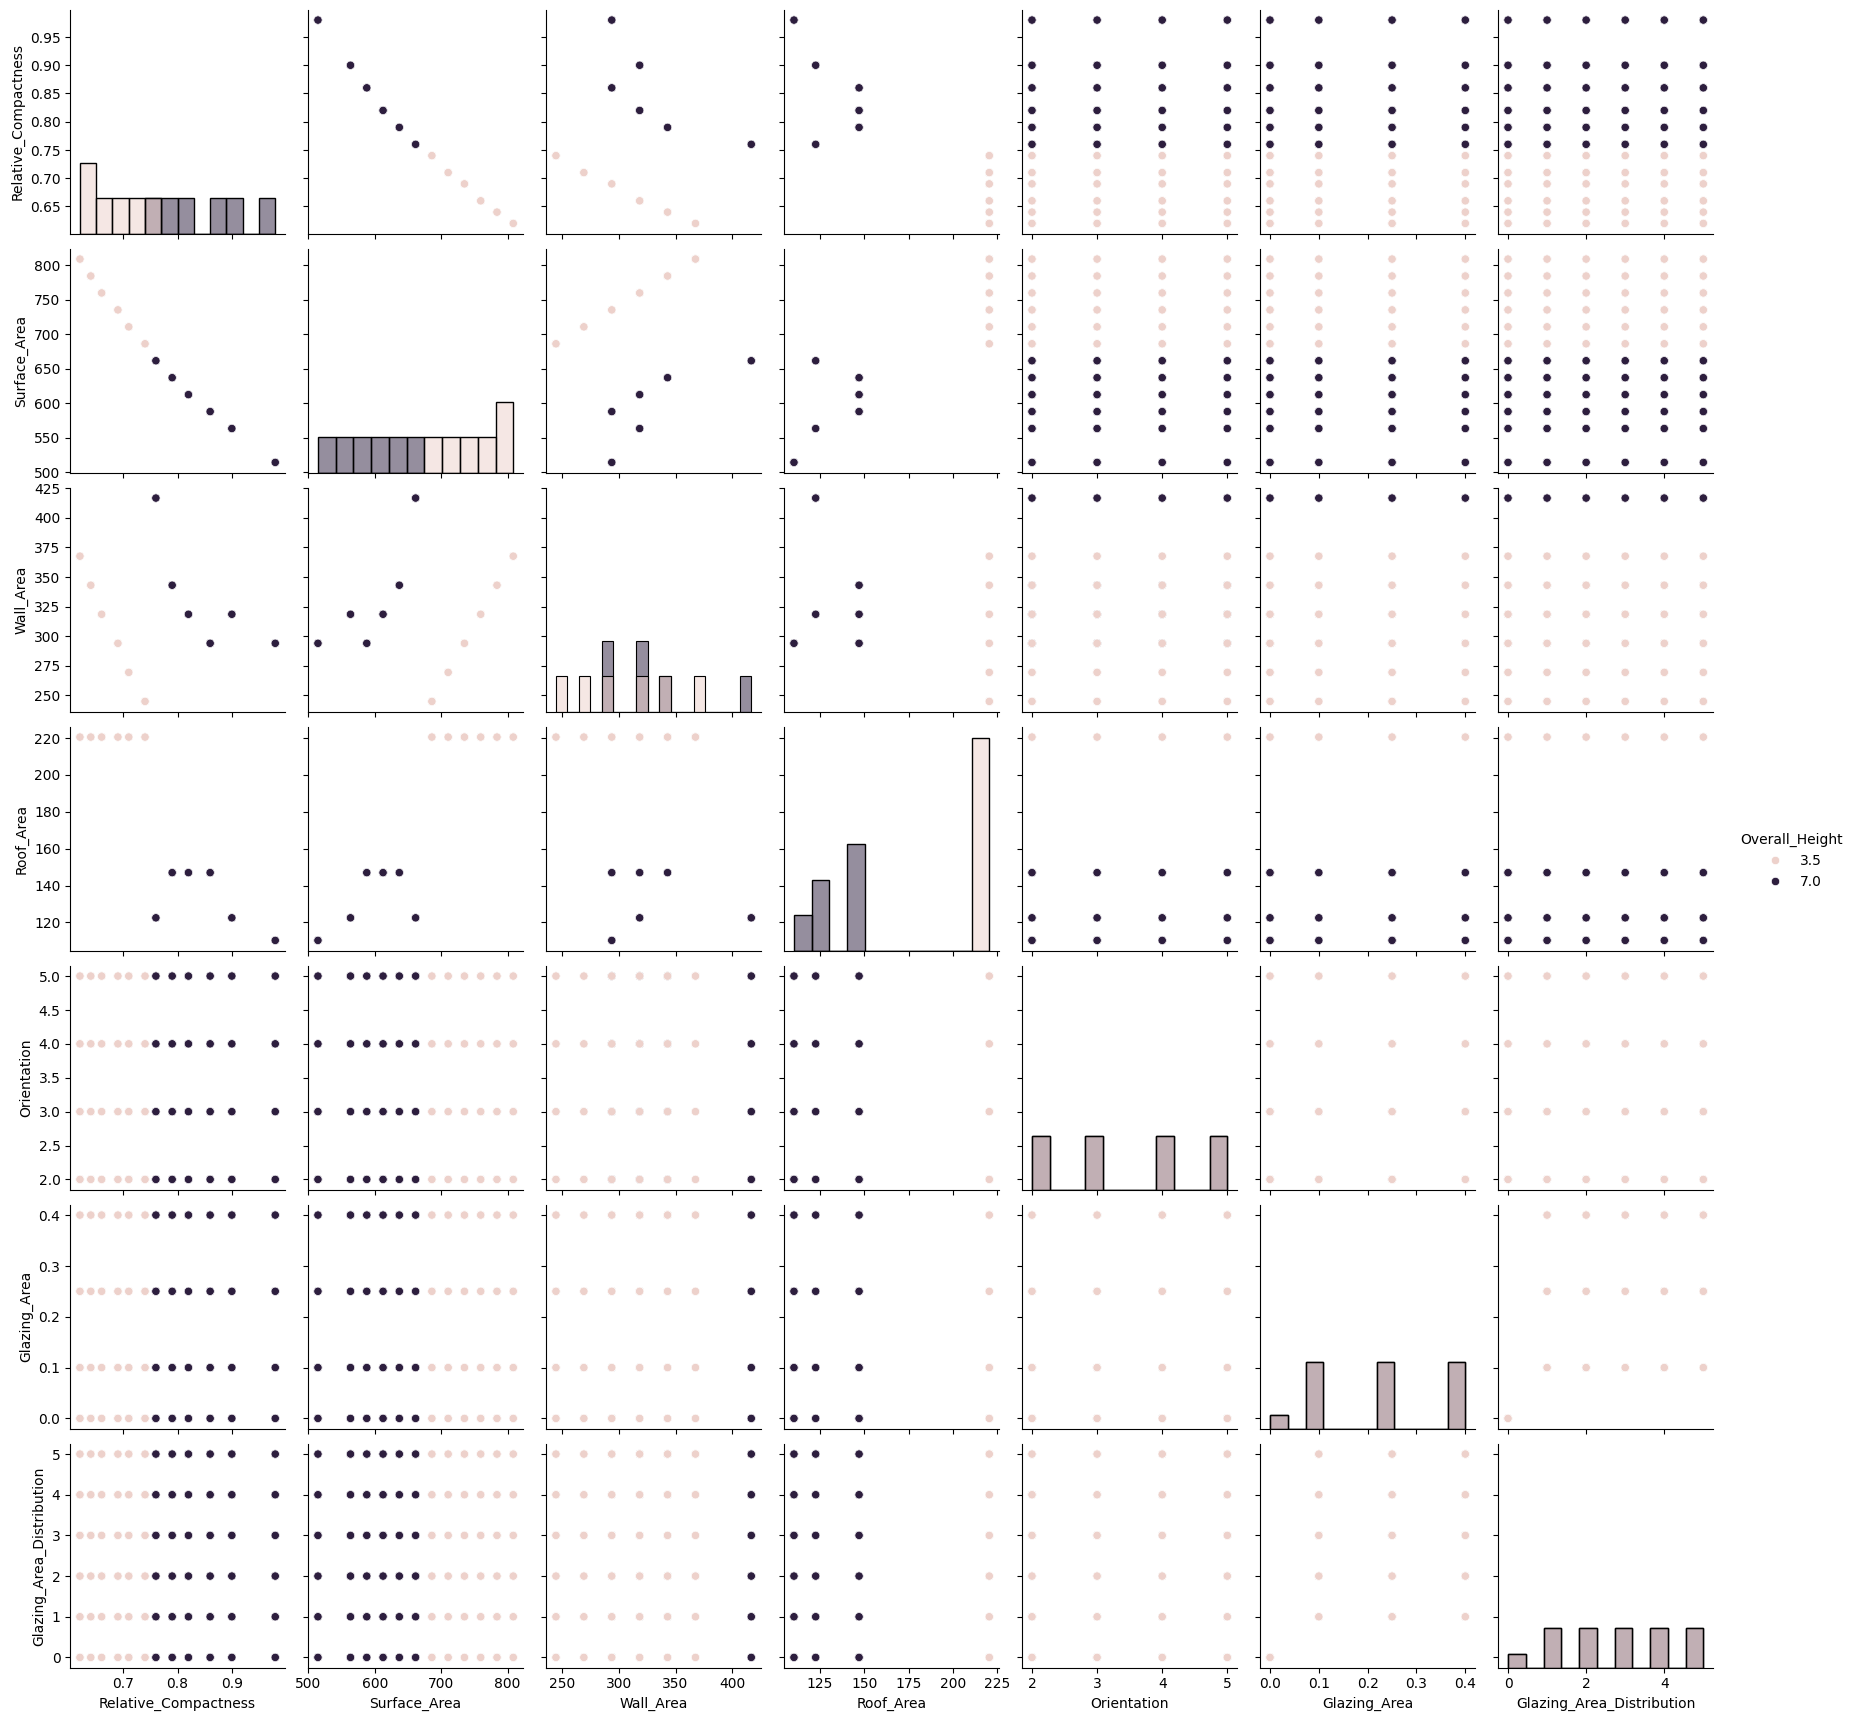

In [51]:
sns.pairplot(X, hue="Overall_Height", diag_kind="hist")

Roof area, surface area, and relative compactness are also dictated by the number of stories. Based on these pairwise plots, we need to split this dataset into 2 categories - 1 story and 2 story buildings.

I can run hypothesis testing to prove that 1 story and 2 story buildings are distinct datasets

In [108]:
# Split the dataset into two groups (1 story and 2 story houses)
df_1 = df[df['Overall_Height'] == 3.5]
df_2 = df[df['Overall_Height'] == 7.0]

# Perform a two-sample t-test to compare the means of the two groups
t_stat, p_val = stats.ttest_ind(df_1['Heating_Load'], df_2['Heating_Load'])

# Print the results
print("The p-value for the heating load test is", p_val)

The p-value for the heating load test is 1.1409232650144011e-262


We can reject the null hypothesis that the heating load of a 1 story house is the same as the heating load of a 2 story house because p < 0.05.

In [109]:
# Perform a two-sample t-test to compare the means of the two groups
t_stat, p_val = stats.ttest_ind(df_1['Cooling_Load'], df_2['Cooling_Load'])

# Print the results
print("The p-value for the cooling load test is", p_val)

The p-value for the cooling load test is 5.8557706130170984e-272


We can also reject the null hypothesis that the cooling load of a 1 story house is the same as the cooling load of a 2 story house because p < 0.05.

Next we'll run some correlation matrices to check for collinearity.

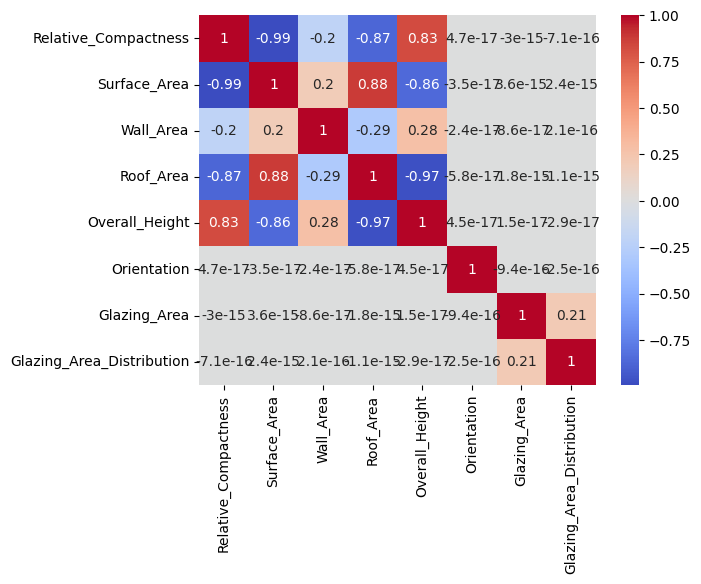

In [110]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Create a heatmap using seaborn
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

I calculated collinearity between some variables, but what happens when I split the dataset into 1 and 2 story houses?

In [111]:
# Split dataset into 1 story houses
X1 = df_1[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']]
yh1 = df_1[['Heating_Load']]
yc1 = df_1[['Cooling_Load']]

# Split dataset into 2 story houses
X2 = df_2[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']]
yh2 = df_2[['Heating_Load']]
yc2 = df_2[['Cooling_Load']]

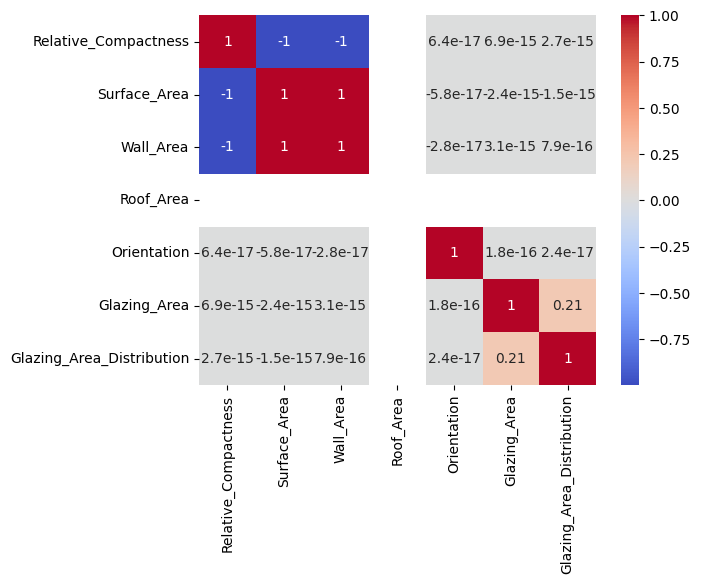

In [112]:
# Calculate the correlation matrix for 1 story houses
correlation_matrix = X1.corr()

# Create a heatmap using seaborn
correlation_matrix = X1.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

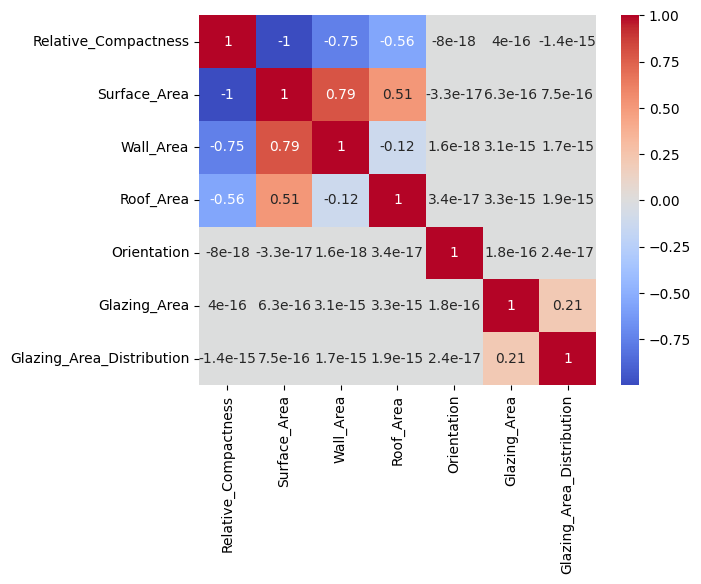

In [113]:
# Calculate the correlation matrix for 2 story houses
correlation_matrix = X2.corr()

# Create a heatmap using seaborn
correlation_matrix = X2.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

For 1 story houses, the wall area and the surface area are highly collinear (basically the exact same variable), less so for 2 story houses.  This makes sense for the geometry of these buildings.  The collinearity I observe is difficult to address without losing major variables inherent in the heat transfer performance of a home.  I can't justify removing a variable unless it later proves to be a weak predictor in the models.

# Model Performance With OLS

Use OLS to check model performance on heating and cooling load

In [114]:
X = sm.add_constant(X)
model_yh = sm.OLS(yh, X)
results = model_yh.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Heating_Load   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     1187.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:29:29   Log-Likelihood:                -1912.5
No. Observations:                 768   AIC:                             3841.
Df Residuals:                     760   BIC:                             3878.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [115]:
model_yc = sm.OLS(yc, X)
results = model_yc.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Cooling_Load   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     859.1
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:29:34   Log-Likelihood:                -1979.3
No. Observations:                 768   AIC:                             3975.
Df Residuals:                     760   BIC:                             4012.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The model is flagging us for collinearity, but we already know we have this issue based on our correlation matrices.  Is it resolved by trying to split the dataset into 1 story and 2 story houses?  

**1 Story Houses**

In [116]:
# 1 Story Houses for Heating Load
X1 = sm.add_constant(X1)
model_yh1 = sm.OLS(yh1, X1)
results = model_yh1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Heating_Load   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     239.4
Date:                Thu, 21 Mar 2024   Prob (F-statistic):          9.72e-115
Time:                        02:29:39   Log-Likelihood:                -647.76
No. Observations:                 384   AIC:                             1308.
Df Residuals:                     378   BIC:                             1331.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Relative_Compactness  

In [117]:
# 1 Story Houses for Cooling Load

model_yc1 = sm.OLS(yc1, X1)
results = model_yc1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Cooling_Load   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     76.85
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.91e-55
Time:                        02:29:43   Log-Likelihood:                -749.20
No. Observations:                 384   AIC:                             1510.
Df Residuals:                     378   BIC:                             1534.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Relative_Compactness  

**2 Story Houses**

In [118]:
# 2 Story Houses for Heating Load
X2 = sm.add_constant(X2)
model_yh2 = sm.OLS(yh2, X2)
results = model_yh2.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Heating_Load   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     180.7
Date:                Thu, 21 Mar 2024   Prob (F-statistic):          1.24e-107
Time:                        02:29:48   Log-Likelihood:                -969.38
No. Observations:                 384   AIC:                             1953.
Df Residuals:                     377   BIC:                             1980.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [119]:
# 2 Story Houses for Cooling Load

model_yc2 = sm.OLS(yc2, X2)
results = model_yc2.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Cooling_Load   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     82.79
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           9.10e-66
Time:                        02:29:52   Log-Likelihood:                -1035.7
No. Observations:                 384   AIC:                             2085.
Df Residuals:                     377   BIC:                             2113.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The correlations between the variables can be more readily seen after splitting the dataset into 1 story and 2 story houses, but the models lose too much accuracy by splitting the dataset into two components.  We will continue using the dataset with both 1 story and 2 story houses together going forward.

# Validate Model Performance

Split the data into training and testing sets using a 70/30 split

In [120]:
X_train, X_test, yh_train, yh_test, yc_train, yc_test = train_test_split(X, yh, yc, test_size=0.3, shuffle=True, random_state=0)

In [121]:
print("shape of X_train is: ", X_train.shape)
print("shape of X_test is: ", X_test.shape)

shape of X_train is:  (537, 9)
shape of X_test is:  (231, 9)


Fit a linear regression model to X and yh

In [122]:
model_yh = LinearRegression()
model_yh.fit(X_train, yh_train)

LinearRegression()

Fit a linear regression model to X and yc

In [123]:
model_yc = LinearRegression()
model_yc.fit(X_train, yc_train)

LinearRegression()

Functions to make predictions and rmse values

In [124]:
def predict(model, X):
  return model.predict(X)

def rmse(model, X, y):
  preds = predict(model, X)
  return np.sqrt(mean_squared_error(y, preds))

Evaluate model performance using RMSE

In [125]:
# Compute rmse_train and rmse_test for heating load response variable
rmse_yh_train = rmse(model_yh, X_train, yh_train)
rmse_yh_test = rmse(model_yh, X_test, yh_test)
# Compute rmse_train and rmse_test for cooling load response variable
rmse_yc_train = rmse(model_yc, X_train, yc_train)
rmse_yc_test = rmse(model_yc, X_test, yc_test)

print("Train RMSE of the heating load linear regression model is: ", rmse_yh_train)
print("Test RMSE of the heating load linear regression model is: ", rmse_yh_test)
print("Train RMSE of the cooling load linear regression model is: ", rmse_yc_train)
print("Test RMSE of the cooling load linear regression model is: ", rmse_yc_test)

Train RMSE of the heating load linear regression model is:  2.872117964007721
Test RMSE of the heating load linear regression model is:  3.0410739418538006
Train RMSE of the cooling load linear regression model is:  3.2212209894355746
Test RMSE of the cooling load linear regression model is:  3.100023878148715


Train and test RMSE are relatively close in magnitude for both response variables so this model is not badly overfitting.  So far, these variables look like solid predictors of the heating and cooling loads of these building shapes.

# Lets try a SHAP explainer to look at feature importance

In [126]:
def SHAP_explainer(model, X):
  explainer = shap.Explainer(model, X)
  shap_values = explainer.shap_values(X)
  # Aggregate SHAP values
  mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
  # Normalize and scale feature importances
  importances = mean_abs_shap_values / np.sum(mean_abs_shap_values) * 100
  # Rank features based on mean absolute SHAP values
  feature_importance = list(zip(X.columns, importances))
  feature_importance.sort(key=lambda x: x[1], reverse=True)

  # Print feature importance ranking
  print("Feature Importance:")
  for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

  # Plot feature importances as a bar chart
  features, importances = zip(*feature_importance)
  plt.figure(figsize=(10, 6))
  plt.bar(features, importances)
  plt.xticks(rotation=90)
  plt.xlabel('Features')
  plt.ylabel('Scaled SHAP Value')
  plt.title('Feature Importance')
  plt.show()

Feature Importance:
Roof_Area: 44.647853935605916
Surface_Area: 38.99009008169241
Wall_Area: 16.36205598266344
Overall_Height: 1.8288071619027633e-11
Relative_Compactness: 1.3391283127731985e-11
Glazing_Area: 5.797544802855483e-12
Glazing_Area_Distribution: 6.077422800532613e-13
Orientation: 1.5020314081689553e-13
const: 0.0


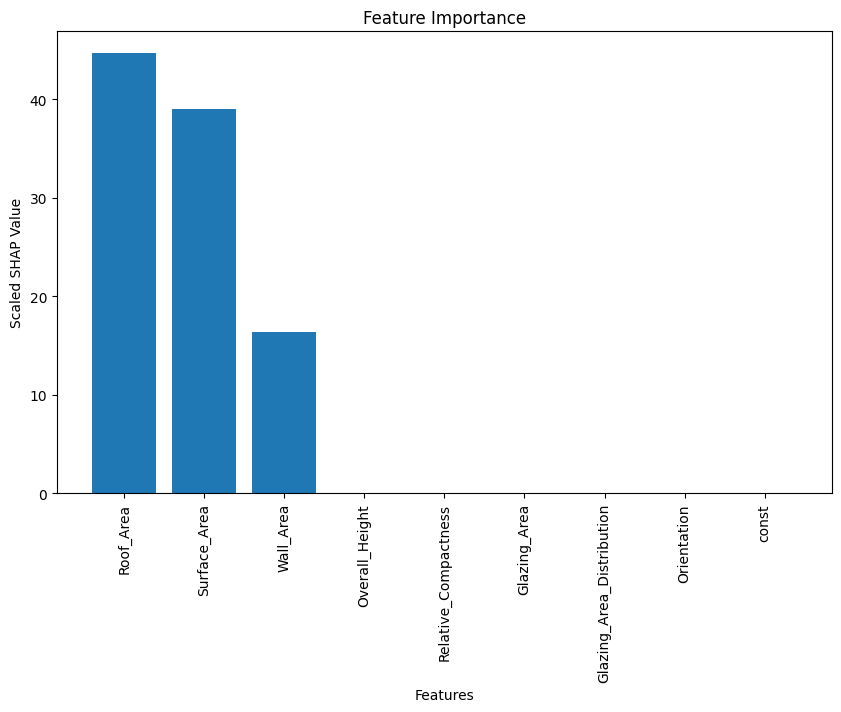

In [127]:
feature_importance_yh = SHAP_explainer(model_yh, X_train)

Feature Importance:
Roof_Area: 44.64785393560893
Surface_Area: 38.990090081702384
Wall_Area: 16.36205598266784
Overall_Height: 1.0239977315003864e-11
Relative_Compactness: 8.126334506072812e-12
Glazing_Area: 2.2813637370105514e-12
Orientation: 1.8073495288894397e-13
Glazing_Area_Distribution: 1.926575769290234e-14
const: 0.0


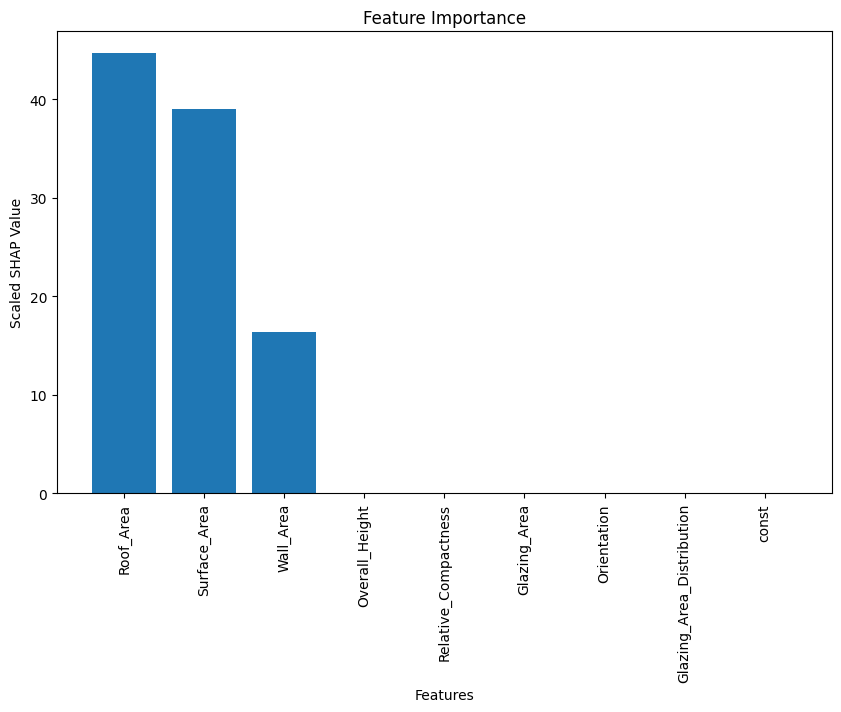

In [128]:
feature_importance_yc = SHAP_explainer(model_yc, X_train)

It does appear that we might be able to drop a few variables and not lose much prediction power with our model. Orientation had a high p value, so it could be dropped from the model.  Unfortunately, we can't manage any collinearity issues by removing variables because our collinearity is tied up with out strongest prediction variables.  All variables will stay in the dataset for now.  Windows don't seem to affect the outcome as much as I'd expected overall, but after running the split dataset OLS predictions, it was clear that these variables do play a prominent roll depending on number of stories and heating versus cooling loads, so even the weakest SHAP prediction variables should remain in the model.

##Regularization

Overfitting isn't terrible so far, but lets try regularization to minimize it.

In [73]:
# Search for Optimal Lambda

rmses_yh_train = []
rmses_yh_test = []
rmses_yc_train = []
rmses_yc_test = []
lambdas = np.logspace(-4, 3, 100)

# Use StandardScaler to normalize train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for l in lambdas:
  # Fit heating load ridge regression model, use l as L-2 reg parameter
  model_yh = Ridge(alpha=l)
  model_yh.fit(X_train_scaled, yh_train)

  # Fit cooling load ridge regression model, use l as L-2 reg parameter
  model_yc = Ridge(alpha=l)
  model_yc.fit(X_train_scaled, yc_train)

  # Compute rmse_train and rmse_test for ridge regression
  rmse_yh_train = rmse(model_yh, X_train_scaled, yh_train)
  rmse_yh_test = rmse(model_yh, X_test_scaled, yh_test)
  rmse_yc_train = rmse(model_yc, X_train_scaled, yc_train)
  rmse_yc_test = rmse(model_yc, X_test_scaled, yc_test)

  # Append the computed rmse_train and rmse_test to rmses_train and rmses_test
  rmses_yh_train.append(rmse_yh_train)
  rmses_yh_test.append(rmse_yh_test)
  rmses_yc_train.append(rmse_yc_train)
  rmses_yc_test.append(rmse_yc_test)

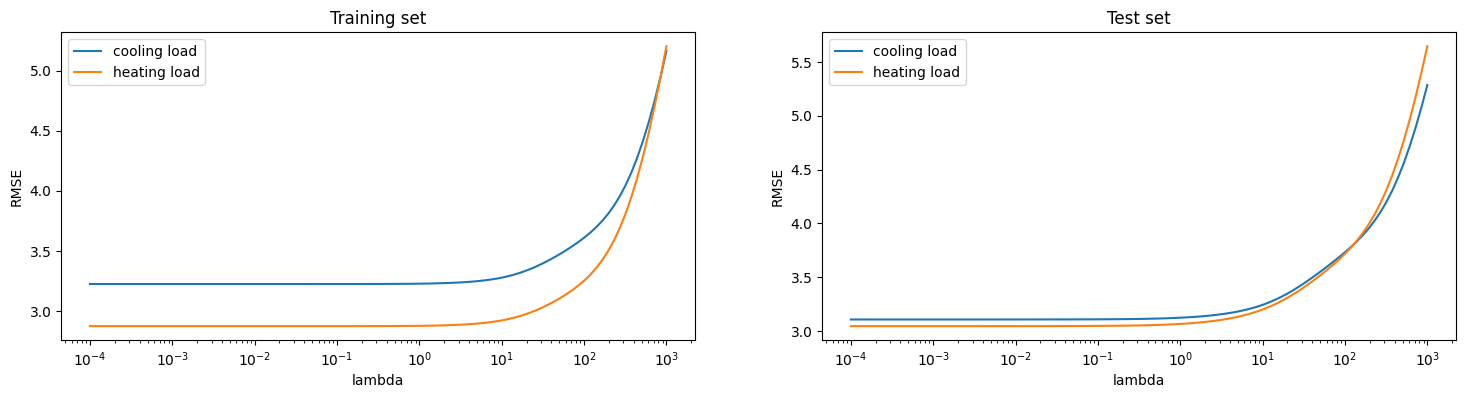

In [74]:
plt.figure(figsize=(18, 4))

plt.subplot(121)
ax = plt.gca()
ax.plot(lambdas, rmses_yc_train)
ax.plot(lambdas, rmses_yh_train)
ax.set_xscale("log")
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.title("Training set")
plt.axis("tight")
plt.legend(["cooling load", "heating load"])

plt.subplot(122)
ax = plt.gca()
ax.plot(lambdas, rmses_yc_test)
ax.plot(lambdas, rmses_yh_test)
ax.set_xscale("log")
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.title("Test set")
plt.axis("tight")
plt.legend(["cooling load", "heating load"])

plt.show()

We'll choose lambda = 0.001 as the Ridge Regression parameter and compute RMSE values

In [75]:
# Use StandardScaler to normalize train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
alpha = 0.001

# Fit heating load lasso regression model, use alpha as L-1 parameter
model_yh = Ridge(alpha=alpha)
model_yh.fit(X_train_scaled, yh_train)

# Fit cooling load ridge regression model, use alpha as L-1 parameter
model_yc = Ridge(alpha=alpha)
model_yc.fit(X_train_scaled, yc_train)

# Compute rmse_train and rmse_test for ridge regression
rmse_yh_train = rmse(model_yh, X_train_scaled, yh_train)
rmse_yh_test = rmse(model_yh, X_test_scaled, yh_test)
rmse_yc_train = rmse(model_yc, X_train_scaled, yc_train)
rmse_yc_test = rmse(model_yc, X_test_scaled, yc_test)

# Print RMSE values
print("Train RMSE of the heating load ridge regression model is: ", rmse_yh_train)
print("Test RMSE of the heating load ridge regression model is: ", rmse_yh_test)
print("Train RMSE of the cooling load ridge regression model is: ", rmse_yc_train)
print("Test RMSE of the cooling load ridge regression model is: ", rmse_yc_test)

Train RMSE of the heating load ridge regression model is:  2.873632796290112
Test RMSE of the heating load ridge regression model is:  3.0439553196685867
Train RMSE of the cooling load ridge regression model is:  3.2241582337843973
Test RMSE of the cooling load ridge regression model is:  3.105690616508843


Very mimimal change using Ridge Regression, so model performance cannot be improved using ridge regression.  

# Try Other Models

In [76]:
# Use StandardScaler to normalize train and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
# Functions to fit models and calculate RMSE and R2 scores

def try_model_r2(model, X_train, y_train, X_test, y_test):
  # Fit model
  model.fit(X_train, y_train)
  # Compute R2 scores
  r2_train = r2_score(y_train, model.predict(X_train))
  r2_test = r2_score(y_test, model.predict(X_test))
  return r2_train, r2_test

def try_model_rmse(model, X_train, y_train, X_test, y_test):
  # Fit model
  model.fit(X_train, y_train)
  # Compute rmse scores
  rmse_train = rmse(model, X_train, y_train)
  rmse_test = rmse(model, X_test, y_test)
  return rmse_train, rmse_test

In [78]:
# Create list for models

models = [['Linear Regression', LinearRegression()],
          ['SVR', SVR()],
          ['KNN', KNeighborsRegressor()],
          ['Random Forest', RandomForestRegressor()],
          ['Decision Tree', DecisionTreeRegressor()],
          ['Bagging', BaggingRegressor()],
          ['AdaBoost', AdaBoostRegressor()],
          ['Gradient Boost', GradientBoostingRegressor()],
          ['XGBoost', XGBRegressor()]]

In [79]:
# Create dataframes for R2 and RMSE values

r2table = pd.DataFrame(columns=['Model', 'Heat R2 Train', 'Heat R2 Test', 'Cool R2 Train', 'Cool R2 Test'])
rmsetable = pd.DataFrame(columns=['Model', 'Heat RMSE Train', 'Heat RMSE Test', 'Cool RMSE Train', 'Cool RMSE Test'])

In [80]:
# try models and return corresponding R2 and RMSE scores

for mod in models:
    model = mod[1]
    heat_r2_train, heat_r2_test = try_model_r2(model, X_train, yh_train.values.ravel(), X_test, yh_test.values.ravel())
    cool_r2_train, cool_r2_test = try_model_r2(model, X_train, yc_train.values.ravel(), X_test, yc_test.values.ravel())
    heat_rmse_train, heat_rmse_test = try_model_rmse(model, X_train, yh_train.values.ravel(), X_test, yh_test.values.ravel())
    cool_rmse_train, cool_rmse_test = try_model_rmse(model, X_train, yc_train.values.ravel(), X_test, yc_test.values.ravel())

    # Create DataFrames for each model's results
    r2_df = pd.DataFrame({'Model': mod[0], 'Heat R2 Train': heat_r2_train, 'Heat R2 Test': heat_r2_test,
                          'Cool R2 Train': cool_r2_train, 'Cool R2 Test': cool_r2_test}, index=[0])
    rmse_df = pd.DataFrame({'Model': mod[0], 'Heat RMSE Train': heat_rmse_train, 'Heat RMSE Test': heat_rmse_test,
                            'Cool RMSE Train': cool_rmse_train, 'Cool RMSE Test': cool_rmse_test}, index=[0])

    # Concatenate the DataFrames to the main tables
    r2table = pd.concat([r2table, r2_df], ignore_index=True)
    rmsetable = pd.concat([rmsetable, rmse_df], ignore_index=True)

In [81]:
r2table

,Model,Heat R2 Train,Heat R2 Test,Cool R2 Train,Cool R2 Test
0,Linear Regression,0.917531,0.911706,0.885002,0.893025
1,SVR,0.930210,0.916238,0.892377,0.889505
2,KNN,0.963612,0.943087,0.950049,0.919558
3,Random Forest,0.999603,0.997164,0.995372,0.968545
4,Decision Tree,1.000000,0.996666,1.000000,0.934652
5,Bagging,0.999603,0.997481,0.993029,0.967208
6,AdaBoost,0.966067,0.967459,0.948174,0.943869
7,Gradient Boost,0.998425,0.997536,0.980189,0.975113
8,XGBoost,0.999981,0.998312,0.999853,0.987202


In [82]:
rmsetable

,Model,Heat RMSE Train,Heat RMSE Test,Cool RMSE Train,Cool RMSE Test
0,Linear Regression,2.874330,3.046655,3.224343,3.106291
1,SVR,2.644155,2.967430,3.119238,3.156984
2,KNN,1.909268,2.446028,2.125048,2.693662
3,Random Forest,0.194368,0.551188,0.649969,1.771828
4,Decision Tree,0.000000,0.589996,0.000000,2.358835
5,Bagging,0.214217,0.565496,0.673886,1.680420
6,AdaBoost,1.819467,1.848830,2.344625,2.464566
7,Gradient Boost,0.397195,0.506423,1.338300,1.498266
8,XGBoost,0.043789,0.421203,0.115116,1.074424


Clearly XGBoost won the race, so we'll fine tune that model for optimal performance.

# Fine Tune XGBoost Model

In [83]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators': [100, 200, 300]
}

In [84]:
# Create the XGBoost regressor
model = xgboost.XGBRegressor()

In [85]:
# Perform grid search with cross-validation for heating load
grid_search_heat = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_heat.fit(X_train, yh_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='neg_mean_squared_error')

In [86]:
# Perform grid search with cross-validation for cooling load
grid_search_cool = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_cool.fit(X_train, yc_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='neg_mean_squared_error')

In [87]:
# Get the best hyperparameters for heating load
best_params_heat = grid_search_heat.best_params_
print("Best Hyperparameters:", best_params_heat)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


In [88]:
# Get the best hyperparameters for cooling load
best_params_cool = grid_search_cool.best_params_
print("Best Hyperparameters:", best_params_cool)

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}


In [89]:
# Train the final model with the best hyperparameters
final_model_heat = xgboost.XGBRegressor(**best_params_heat)
final_model_heat.fit(X_train, yh_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [90]:
# Train the final model with the best hyperparameters
final_model_cool = xgboost.XGBRegressor(**best_params_cool)
final_model_cool.fit(X_train, yh_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Assess Performance of Final XGBoost Models

In [91]:
# Show feature importances for XGBoost heating load model
final_model_heat.feature_importances_

array([0.0000000e+00, 8.5037404e-01, 0.0000000e+00, 2.0335665e-02,
       1.0194349e-02, 0.0000000e+00, 4.4448540e-04, 1.1812269e-01,
       5.2880647e-04], dtype=float32)

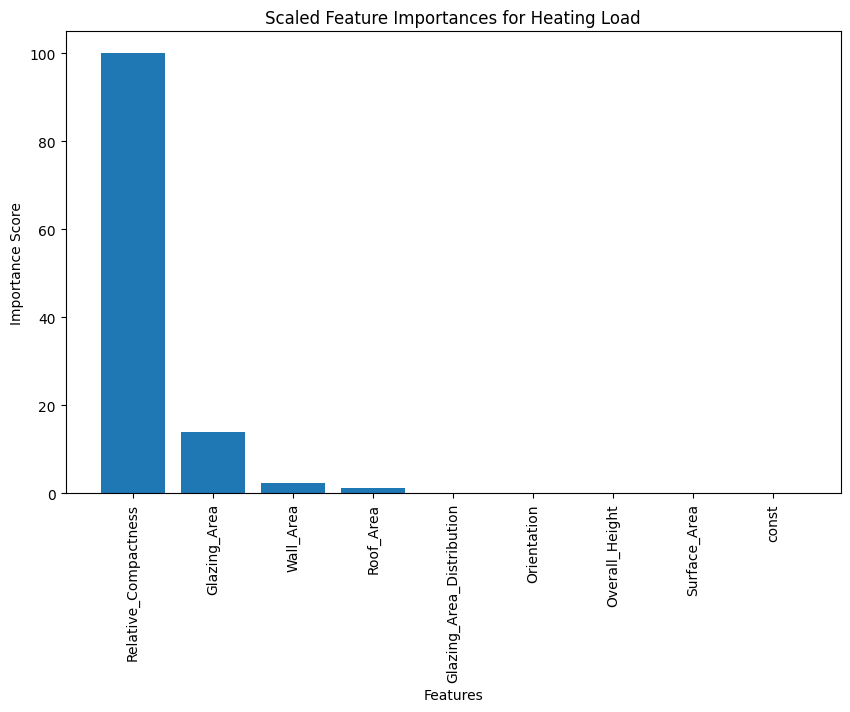

In [92]:
# Show XGBoost model feature importances for heating load

# Get feature importances
feature_importances = final_model_heat.feature_importances_
scaled_importances = (feature_importances / np.max(feature_importances)) * 100
# Get feature names
feature_names = X.columns
# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(scaled_importances)), scaled_importances[sorted_idx], align='center')
plt.xticks(range(len(scaled_importances)), feature_names[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Scaled Feature Importances for Heating Load')
plt.show()

In [93]:
# Show feature importances for XGBoost cooling load model
final_model_cool.feature_importances_

array([0.0000000e+00, 8.8044566e-01, 0.0000000e+00, 9.8230410e-03,
       2.0325233e-03, 0.0000000e+00, 6.4448680e-04, 1.0617730e-01,
       8.7702653e-04], dtype=float32)

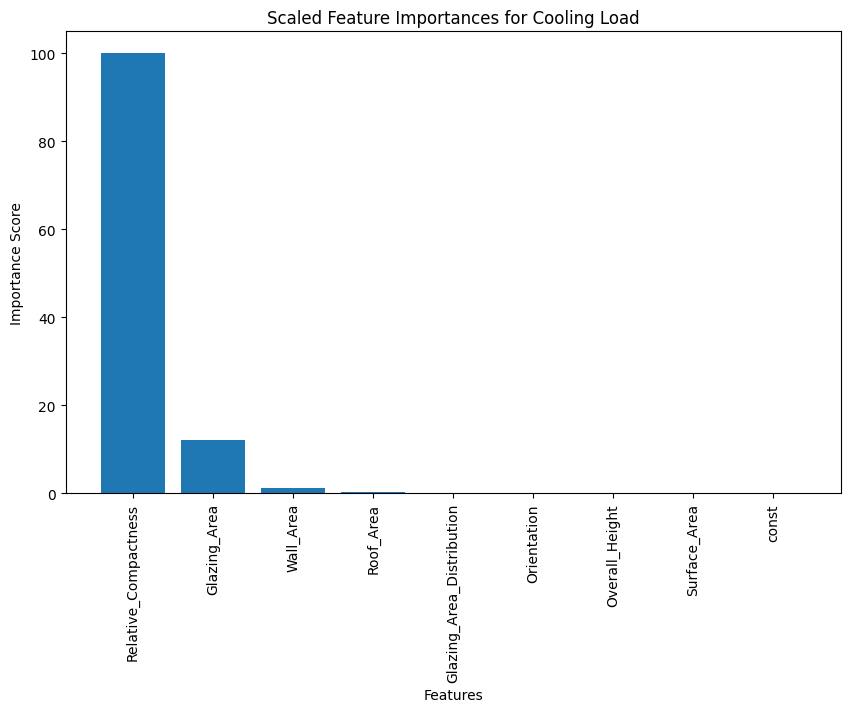

In [94]:
# Show XGBoost model feature importances for cooling load

# Get feature importances
feature_importances = final_model_cool.feature_importances_
scaled_importances = (feature_importances / np.max(feature_importances)) * 100
# Get feature names
feature_names = X.columns
# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(scaled_importances)), scaled_importances[sorted_idx], align='center')
plt.xticks(range(len(scaled_importances)), feature_names[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Scaled Feature Importances for Cooling Load')
plt.show()

In [95]:
# Make predictions on the test set
y_pred_heat = final_model_heat.predict(X_test)
y_pred_cool = final_model_cool.predict(X_test)

# Compute R-squared (R2)
r2_heat = r2_score(yh_test, y_pred_heat)
r2_cool = r2_score(yc_test, y_pred_cool)
print("R-squared (R2) Heat:", r2_heat)
print("R-squared (R2) Cool:", r2_cool)

# Compute MAE scores
mae_heat = mean_absolute_error(yh_test, y_pred_heat)
mae_cool = mean_absolute_error(yc_test, y_pred_cool)
print("MAE Heat:", mae_heat)
print("MAE Cool:", mae_cool)

# Compute RMSE scores
rmse_heat = np.sqrt(mean_squared_error(yh_test, y_pred_heat))
rmse_cool = np.sqrt(mean_squared_error(yc_test, y_pred_cool))
print("RMSE Heat:", rmse_heat)
print("RMSE Cool:", rmse_cool)

R-squared (R2) Heat: 0.9982546088862212
R-squared (R2) Cool: 0.8950933088342261
MAE Heat: 0.2843591927037094
MAE Cool: 2.591594158189121
RMSE Heat: 0.4283542351293947
RMSE Cool: 3.0761135738214676
